In [1]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib

In [2]:
import zipfile
with zipfile.ZipFile(r"C:\Users\world\Downloads\driver_drowsiness_detection_modified.zip",'r') as zip_ref:
    zip_ref.extractall(r"C:\Users\world\Downloads")

In [3]:
data = np.load(r"C:\Users\world\Downloads\driver_drowsiness_detection\dataset_compressed.npz", allow_pickle=True)
X = data['arr_0']
Y = data['arr_1']

X = list(X)
Y = list(Y)
print(len(X))
print(len(Y))

1452
1452


In [4]:
for i in range(len(X)):
    img = X[i]
    img = cv2.resize(img, (32, 32))
    X[i] = img
    
print(len(X))
print(X[0].shape)

1452
(32, 32, 3)


In [30]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)
print(set(Y))

(1452,)
{0, 1}


In [6]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(1452, 32, 32, 3)
(1452,)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [8]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1161, 32, 32, 3)
(1161,)
(291, 32, 32, 3)
(291,)
(1161, 32, 32, 3)
(1161, 2)
(291, 32, 32, 3)
(291, 2)


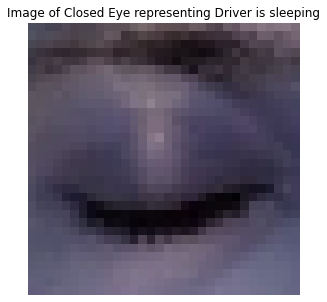

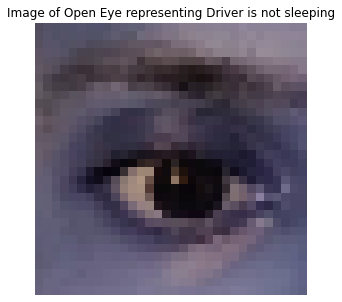

In [9]:
figure1 = plt.figure(figsize=(5, 5))
idx_closed = np.where(Y==0)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title('Image of Closed Eye representing Driver is sleeping')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_open = np.where(Y==1)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title('Image of Open Eye representing Driver is not sleeping')
plt.axis('off')
plt.show()

In [14]:
def driver_drowsiness_detection_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    
    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model= driver_drowsiness_detection_model(input_shape=(32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0

In [18]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=80, validation_data=(X_test, Y_test))

Epoch 1/80
10/10 [==============================] - 5s 491ms/step - loss: 0.0789 - accuracy: 0.9733 - val_loss: 0.0749 - val_accuracy: 0.9656
Epoch 2/80
10/10 [==============================] - 5s 523ms/step - loss: 0.0936 - accuracy: 0.9664 - val_loss: 0.0747 - val_accuracy: 0.9725
Epoch 3/80
10/10 [==============================] - 5s 474ms/step - loss: 0.0732 - accuracy: 0.9724 - val_loss: 0.0767 - val_accuracy: 0.9725
Epoch 4/80
10/10 [==============================] - 5s 469ms/step - loss: 0.0849 - accuracy: 0.9733 - val_loss: 0.0775 - val_accuracy: 0.9656
Epoch 5/80
10/10 [==============================] - 5s 474ms/step - loss: 0.0866 - accuracy: 0.9673 - val_loss: 0.0732 - val_accuracy: 0.9725
Epoch 6/80
10/10 [==============================] - 5s 477ms/step - loss: 0.0718 - accuracy: 0.9724 - val_loss: 0.0698 - val_accuracy: 0.9691
Epoch 7/80
10/10 [==============================] - 5s 528ms/step - loss: 0.0651 - accuracy: 0.9733 - val_loss: 0.0682 - val_accuracy: 0.9725
Epoch 

10/10 [==============================] - 5s 523ms/step - loss: 0.0316 - accuracy: 0.9888 - val_loss: 0.0413 - val_accuracy: 0.9863
Epoch 59/80
10/10 [==============================] - 5s 514ms/step - loss: 0.0410 - accuracy: 0.9871 - val_loss: 0.0410 - val_accuracy: 0.9863
Epoch 60/80
10/10 [==============================] - 5s 597ms/step - loss: 0.0450 - accuracy: 0.9819 - val_loss: 0.0425 - val_accuracy: 0.9863
Epoch 61/80
10/10 [==============================] - 5s 530ms/step - loss: 0.0430 - accuracy: 0.9819 - val_loss: 0.0399 - val_accuracy: 0.9863
Epoch 62/80
10/10 [==============================] - 5s 523ms/step - loss: 0.0319 - accuracy: 0.9871 - val_loss: 0.0413 - val_accuracy: 0.9863
Epoch 63/80
10/10 [==============================] - 6s 601ms/step - loss: 0.0414 - accuracy: 0.9802 - val_loss: 0.0391 - val_accuracy: 0.9863
Epoch 64/80
10/10 [==============================] - 7s 671ms/step - loss: 0.0374 - accuracy: 0.9854 - val_loss: 0.0432 - val_accuracy: 0.9828
Epoch 65/80

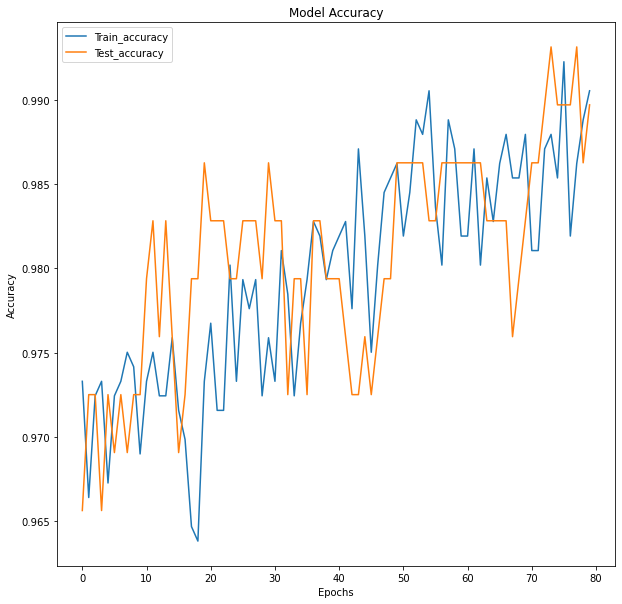

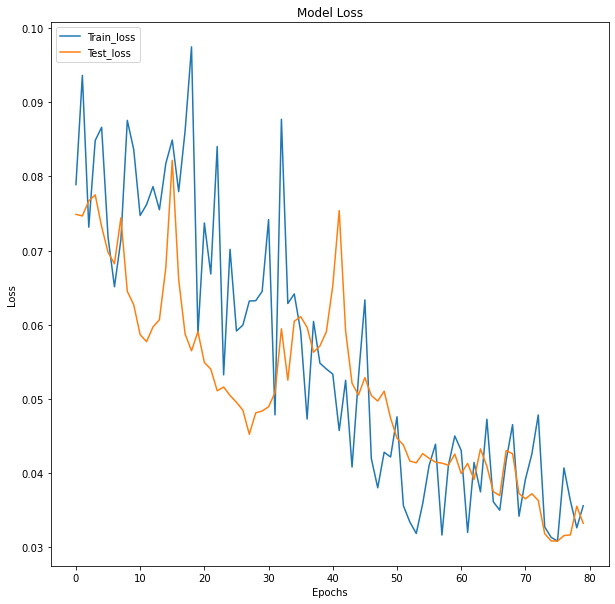

In [19]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [20]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

10/10 [==============================] - 0s 28ms/step - loss: 0.0332 - accuracy: 0.9897
Test Set Accuracy: 0.9896907210350037
Test Set Loss: 0.033177074044942856


In [21]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

10/10 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       140
           1       0.99      0.99      0.99       151

    accuracy                           0.99       291
   macro avg       0.99      0.99      0.99       291
weighted avg       0.99      0.99      0.99       291



<AxesSubplot:>

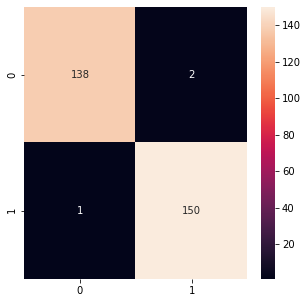

In [22]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [23]:
model.save('Driver_Drowsiness_Detection.h5')

In [32]:
labels = ['Closed', 'Open']
img_closed1 = cv2.imread(r"C:\Users\world\Downloads\driver_drowsiness_detection\closed_eye.jpg")
img_open1 = cv2.imread(r"C:\Users\world\Downloads\driver_drowsiness_detection\open_eye.jpg")


img_closed1 = cv2.resize(img_closed1, (32, 32))
img_open1 = cv2.resize(img_open1, (32, 32))

img_closed1 = np.array(img_closed1)
img_open1 = np.array(img_open1)

img_closed1 = np.expand_dims(img_closed1, axis=0)
img_open1 = np.expand_dims(img_open1, axis=0)

In [33]:
ypred_closed1 = model.predict(img_closed1)
ypred_open1 = model.predict(img_open1)

1/1 [==============================] - 0s 44ms/step


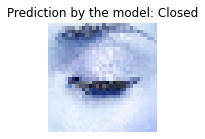

In [26]:
figure = plt.figure(figsize=(2, 2))
img_closed1 = np.squeeze(img_closed1, axis=0)
plt.imshow(img_closed1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed1[0], axis=0)]}')
plt.show()

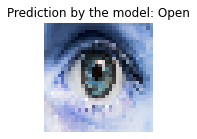

In [28]:
figure = plt.figure(figsize=(2, 2))
img_open1 = np.squeeze(img_open1, axis=0)
plt.imshow(img_open1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open1[0], axis=0)]}')
plt.show()